In [56]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from time import sleep

def calc_tile(files):
    new_im = Image.new('RGB', (1000,1000), (100,100,100))
    index = 0
    for i in range(0,1000,100):
        j = 0
        while (j < 1000):
            if (index >= len(files)-1):
                return new_im
            try:
                image = Image.open(files[index])                
            except Exception as e:
                print(e, ": ", files[index], "py exists: ", os.path.isfile(files[index]), '\n' )
                index += 1
                continue
            width  = image.size[0]
            height = image.size[1]

            aspect = width / float(height)

            ideal_width = 100
            ideal_height = 100

            ideal_aspect = ideal_width / float(ideal_height)

            if aspect > ideal_aspect:
                # Then crop the left and right edges:
                new_width = int(ideal_aspect * height)
                offset = (width - new_width) / 2
                resize = (offset, 0, width - offset, height)
            else:
                # ... crop the top and bottom:
                new_height = int(width / ideal_aspect)
                offset = (height - new_height) / 2
                resize = (0, offset, width, height - offset)

            thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)
            new_im.paste(thumb, (i,j))
            index += 1
            j += 100
    return new_im

### Generating image tiles from the base dataset without preprocessing

In [2]:
ethn_df = pd.read_csv("../Images/GenderEthnicityResources/binned_id_gender_ethnicity.csv")
ethn_df.head()

Unnamed: 0           id  gender  ethnicity
0           0   3211298559       1  caucasian
1           1  82733984485       1  caucasian
2           2  99029428429       0  caucasian
3           3  71174220620       1  caucasian
4           4  47408331317       1  caucasian

In [3]:
ethn_df['id'] = ethn_df['id'].apply(pd.to_numeric)
ethn_df.dtypes

Unnamed: 0     int64
id             int64
gender         int64
ethnicity     object
dtype: object

In [4]:
source = '../Images/GenderEthnicityResources/photos/'
numPics = pd.DataFrame([int(f[:-5]) for f in os.listdir(source) if f.endswith('.jpg')], columns=["id"])
print(numPics.dtypes)


print(ethn_df['id'].isin(numPics['id']).value_counts())
joined = pd.merge(numPics, ethn_df, how='inner', on="id")

id    int64
dtype: object
False    30856631
True      1426142
Name: id, dtype: int64


In [10]:
samples = {}
for ethnicity in joined['ethnicity'].unique():
    temp = joined[joined['ethnicity']==ethnicity]
    print(ethnicity, temp.shape)
    samples[ethnicity] = list(temp.sample(200)['id'])

hispanic (326346, 4)
eastasian (61716, 4)
caucasian (920223, 4)
southasian (109197, 4)
african (8660, 4)


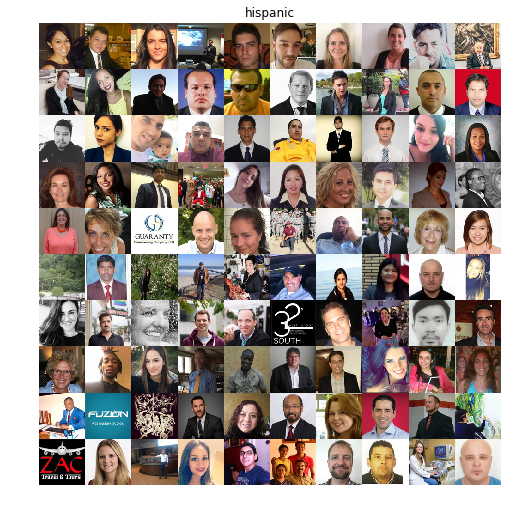

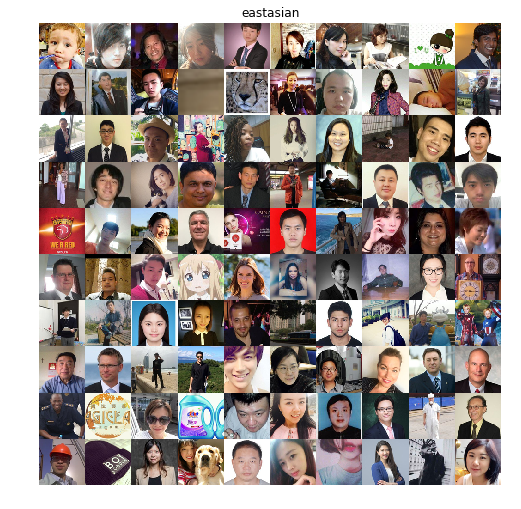

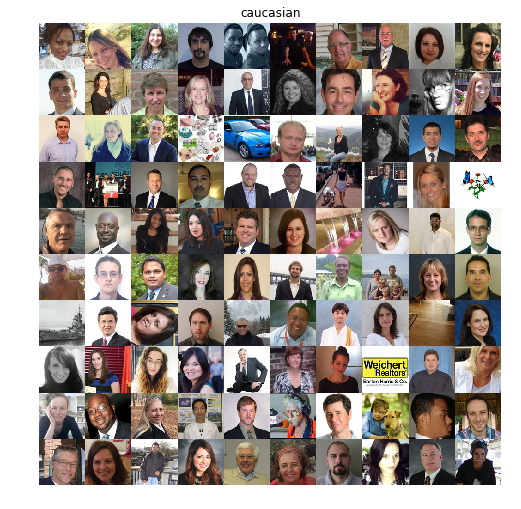

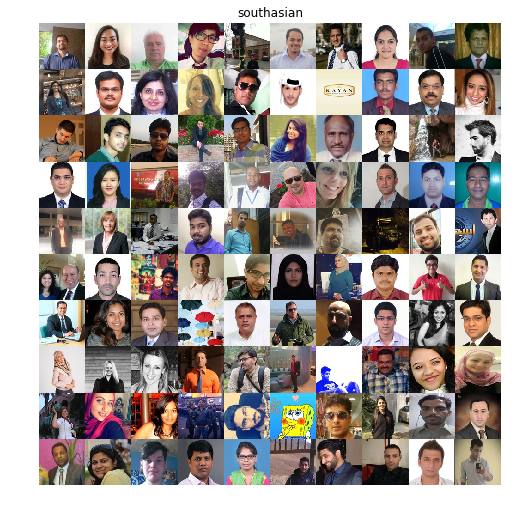

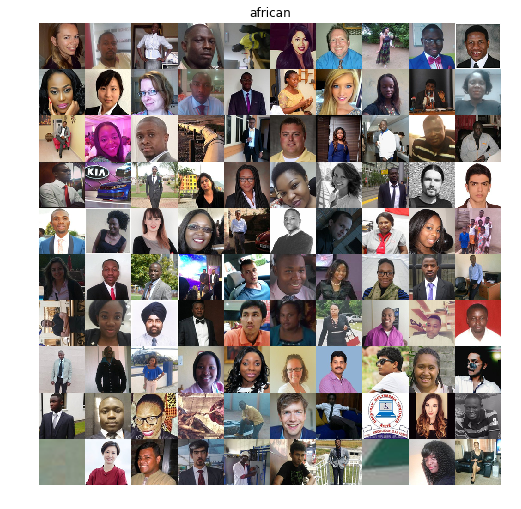

In [11]:
images = []
cols = 2
titles = list(samples)
for i in titles:
    vis = []
    for pic in samples[i]:
        vis.append("../Images/GenderEthnicityResources/photos/"+str(pic)+"..jpg")
    images.append(calc_tile(vis))    

n_images = len(images)
for n, (image, title) in enumerate(zip(images, titles)):
    fig = plt.figure()
    a = fig.add_subplot(cols, np.ceil(n_images), 1)
    plt.imshow(image)
    plt.imsave(title+"-non_preproc2.jpg", image)
    a.set_title(title)
    plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * 8)
    plt.show()
    sleep(2)


### Generating tiles for the preprocessed base dataset

In [23]:
OF_labels = pd.read_csv("./OF_featurelist/labels.csv", header=None, names=["drop", "id"])
OF_labels["id"] = OF_labels["id"].apply(lambda x: x.split("/")[-1][:-4]) 
OF_labels['id'] = OF_labels['id'].apply(pd.to_numeric)
eth_df = pd.read_csv("../Images/GenderEthnicityResources/binned_id_gender_ethnicity.csv")
joined = pd.merge(eth_df, OF_labels, how='right', on="id")
joined =  joined.dropna()
joined.head()

Unnamed: 0           id  gender  ethnicity  drop
0      3295.0  54292118493     0.0  eastasian     1
1      4158.0  99321438255     0.0   hispanic     1
2      4223.0  73014823921     2.0  caucasian     1
3      5488.0  98450990289     2.0   hispanic     1
4      5678.0  43487035569     2.0  caucasian     1

eastasian (521, 5)
hispanic (3027, 5)
caucasian (8417, 5)
southasian (894, 5)
african (66, 5)
not enough pics: 66
[Errno 2] No such file or directory: '../Capstone/OF_Aligned/images/16040511274.png' :  14


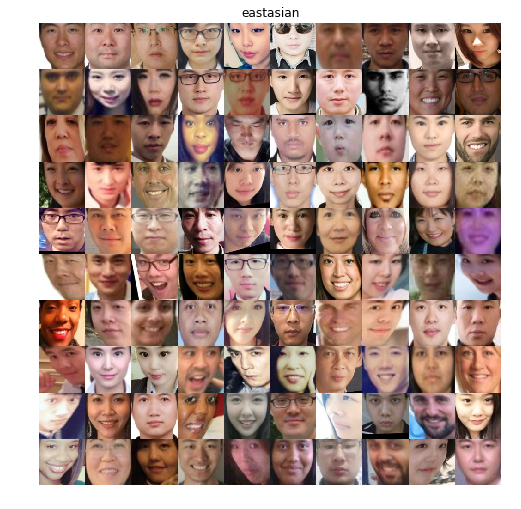

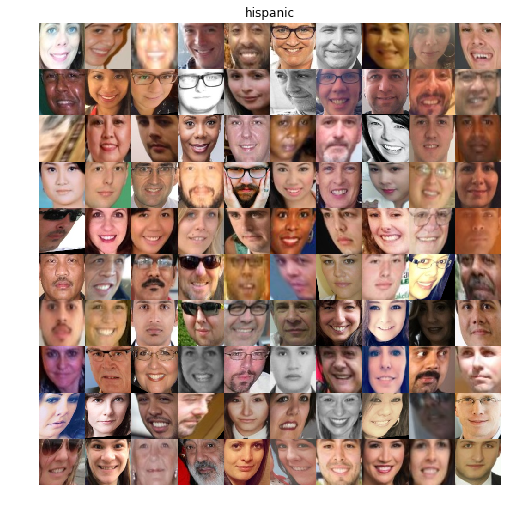

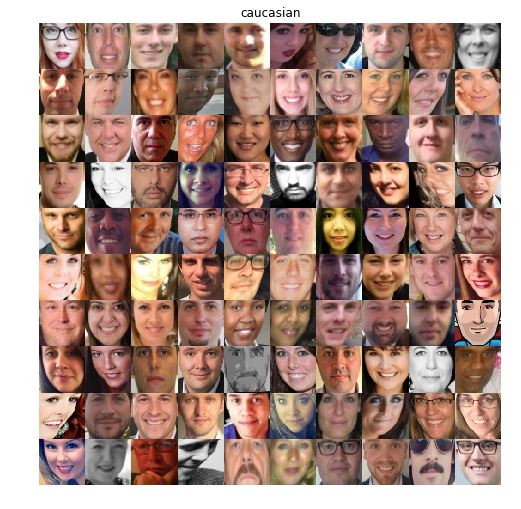

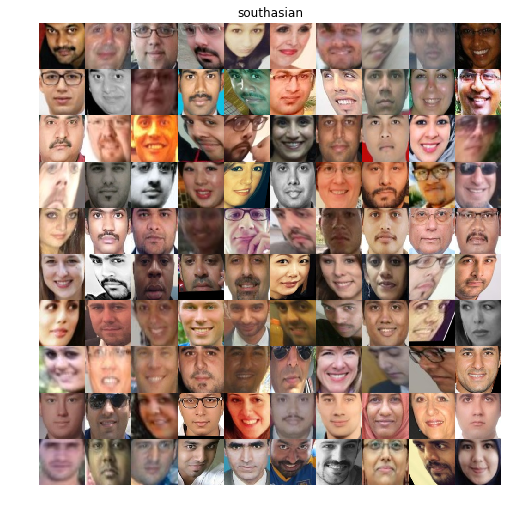

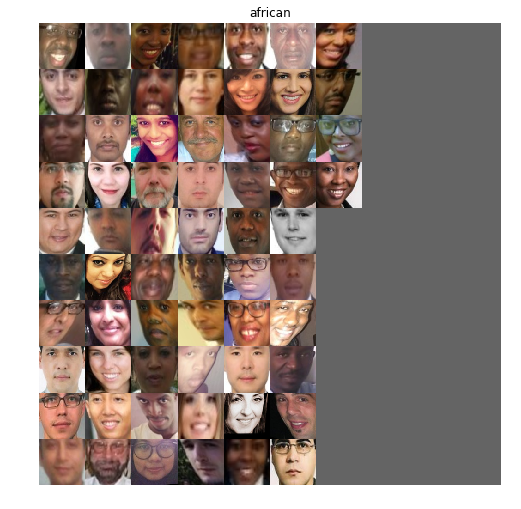

In [29]:
samples = {}
for ethnicity in joined['ethnicity'].unique():
    temp = joined[joined['ethnicity']==ethnicity]
    print(ethnicity, temp.shape)
    if (temp.shape[0]<200):
        print("not enough pics:", temp.shape[0])
        samples[ethnicity] = list(temp.sample(temp.shape[0])['id'])
    else:
        samples[ethnicity] = list(temp.sample(200)['id'])
    
images = []
cols = 2
titles = list(samples)
for i in titles:
    vis = []
    for pic in samples[i]:
        vis.append("../Capstone/OF_Aligned/images/"+str(pic)+".png")
    images.append(calc_tile(vis))    

n_images = len(images)
for n, (image, title) in enumerate(zip(images, titles)):
    fig = plt.figure()
    a = fig.add_subplot(cols, np.ceil(n_images), 1)
    plt.imshow(image)
    plt.imsave(title+"-preproc2.jpg", image)
    a.set_title(title)
    plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * 8)
    plt.show()
    sleep(2)


### Generating tiles for images in the FERET DB

In [65]:
OF_labels = pd.read_csv("./FERET_Dataset/labels.csv", header=None, names=["drop", "id"])
OF_labels["id"] = OF_labels["id"].apply(lambda x: x.split("/")[-1][:-4]) 

feret_table = pd.read_pickle("./FERET_Dataset/gender_table")
feret_table["path"] = feret_table["path"].apply(lambda x: x.split("/")[-1][:-5])
feret_table.rename(inplace = True, columns={"path": "id"})
feret_table.rename(inplace = True, columns={"race": "ethnicity"})

joined = pd.merge(feret_table, OF_labels, how='right', on="id")
feret_table['ethnicity'].value_counts()
joined.head()

gender               id ethnicity  drop
0   Male  00108_960530_ql   african     1
1   Male  00108_941031_rd   african     1
2   Male  00108_960530_ra   african     1
3   Male  00108_960530_rc   african     1
4   Male  00108_931230_fb   african     1

african (645, 4)
caucasian (5150, 4)
southasian (465, 4)
eastasian (1549, 4)
other (117, 4)
not enough pics: 117
hispanic (447, 4)


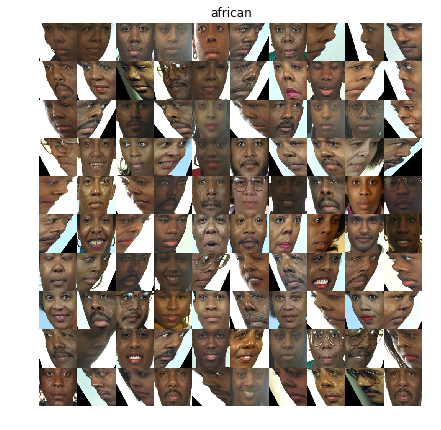

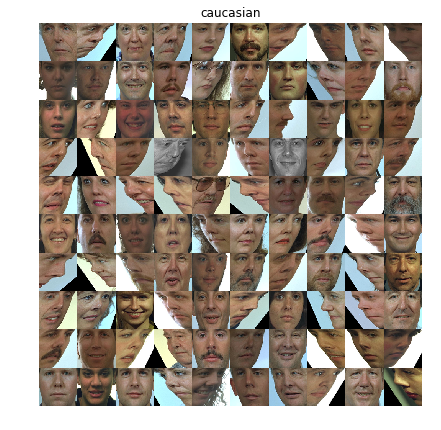

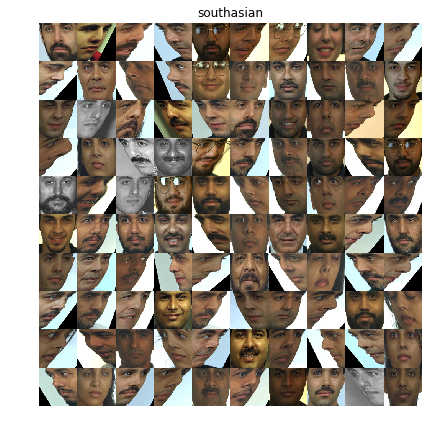

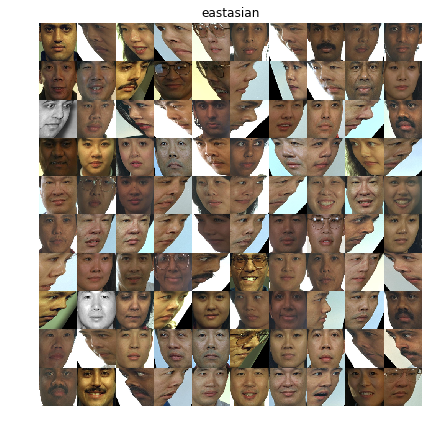

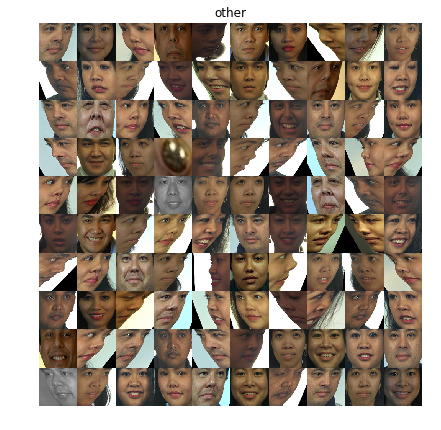

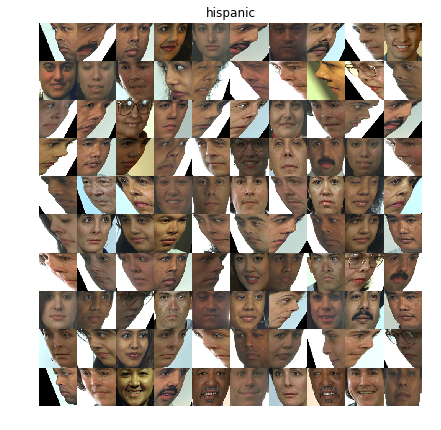

In [66]:
samples = {}
for ethnicity in joined['ethnicity'].unique():
    temp = joined[joined['ethnicity']==ethnicity]
    print(ethnicity, temp.shape)
    if (temp.shape[0]<200):
        print("not enough pics:", temp.shape[0])
        samples[ethnicity] = list(temp.sample(temp.shape[0])['id'])
    else:
        samples[ethnicity] = list(temp.sample(200)['id'])
    
images = []
cols = 2
titles = list(samples)
for i in titles:
    vis = []
    for pic in samples[i]:
        vis.append("../Images/FeretDataset/Aligned_Flat_Folder/Images/"+pic+".png")
    images.append(calc_tile(vis))    

n_images = len(images)
for n, (image, title) in enumerate(zip(images, titles)):
    fig = plt.figure()
    a = fig.add_subplot(cols, np.ceil(n_images), 1)
    plt.imshow(image)
    plt.imsave(title+"-FERET_preproc2.jpg", image)
    a.set_title(title)
    plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * 8)
    plt.show()
    sleep(2)
